<a href="https://colab.research.google.com/github/rg-smith/remote_sensing_course/blob/main/lectures/lecture9/remote_sensing_ML_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### In-class assignment: Machine Learning with Python

In this assignment, we will repeat some of the exercises from Lab 10, but in python. You will see how with python, we can see what the model is doing with more detail than the simplified version in ArcMap.

First, we will install the required packages: rasterio and geopandas. This is done outside of python (the ! character runs from the command line).

In [1]:
!pip install rasterio geopandas
!git clone https://github.com/rg-smith/remote_sensing_course.git

     |████████████████████████████████| 19.1MB 1.4MB/s 
     |████████████████████████████████| 1.0MB 45.1MB/s 
     |████████████████████████████████| 15.3MB 160kB/s 
     |████████████████████████████████| 6.5MB 30.2MB/s 
Cloning into 'remote_sensing_course'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 269 (delta 7), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (269/269), 94.88 MiB | 33.77 MiB/s, done.
Resolving deltas: 100% (70/70), done.


With the required packages installed, we will now load them as well as other packages that are installed automatically with Google Colab.

In [2]:
import rasterio
import geopandas
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from rasterio.plot import show

Now, we will load in the raster. We'll use the python package 'rasterio'.

In [23]:
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['figure.dpi'] = 100

r=rasterio.open('remote_sensing_course/lectures/lecture9/20190316_compressed_100m.tif')

(1, 2, 3, 4, 5, 6, 7, 8)


Next, we'll plot the raster. Plot different bands by replacing 'band number' with a number, 1 through 8.

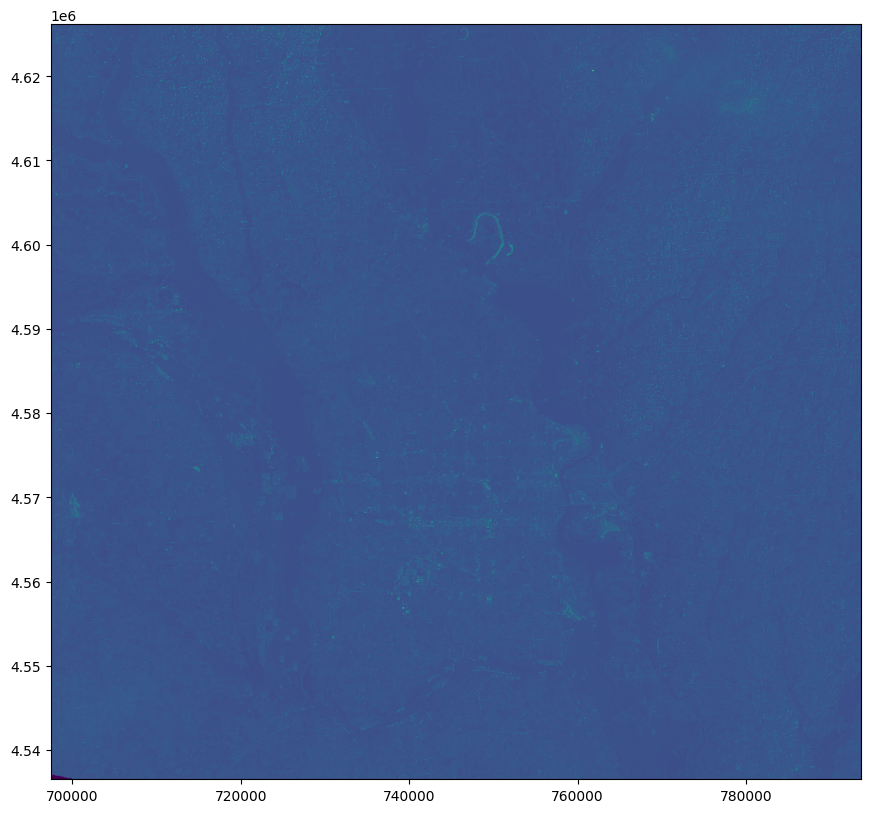

In [21]:
show(r.read(<band number>),transform=r.transform)

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


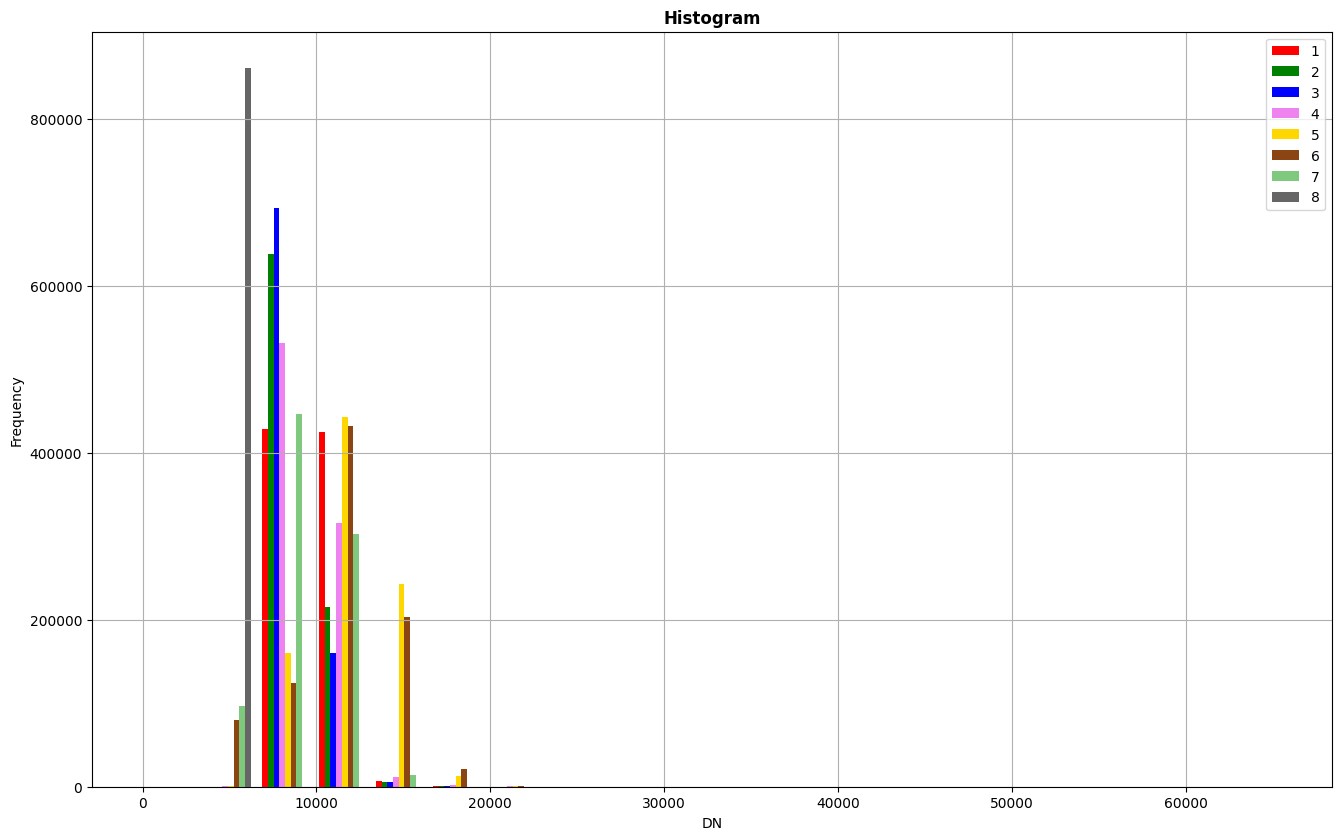

In [9]:
rasterio.plot.show_hist(r,bins=20)

Now we will load the training data that you created in Lab 10. Find the shapefile (there will be multiple files with the same name but different extensions). Drag all of these files into the 'Files' tab in Goolge Colab. Then replace the shapefile_name variable below with the name of your shapefile, in quotes, with the .shp extension.

In [19]:
shapefile_name = 'replace with the name of your shapefile (include .shp extension)'
shp=geopandas.read_file(shapefile_name)
print(shp)

   Classname  ...                                           geometry
0      water  ...  MULTIPOLYGON (((722786.547 4587547.973, 722389...
1       soil  ...  POLYGON ((732476.931 4580545.761, 731869.711 4...
2      urban  ...  MULTIPOLYGON (((748546.569 4570971.339, 748479...
3        ice  ...  MULTIPOLYGON (((763029.297 4567096.709, 763537...
4       crop  ...  MULTIPOLYGON (((755289.681 4610333.617, 753933...
5       snow  ...  MULTIPOLYGON (((775990.935 4600599.852, 775981...
6  vegetated  ...  MULTIPOLYGON (((746203.813 4564289.259, 746176...

[7 rows x 7 columns]


Now plot this shapefile with a few different bands from the Landsat 8 image.

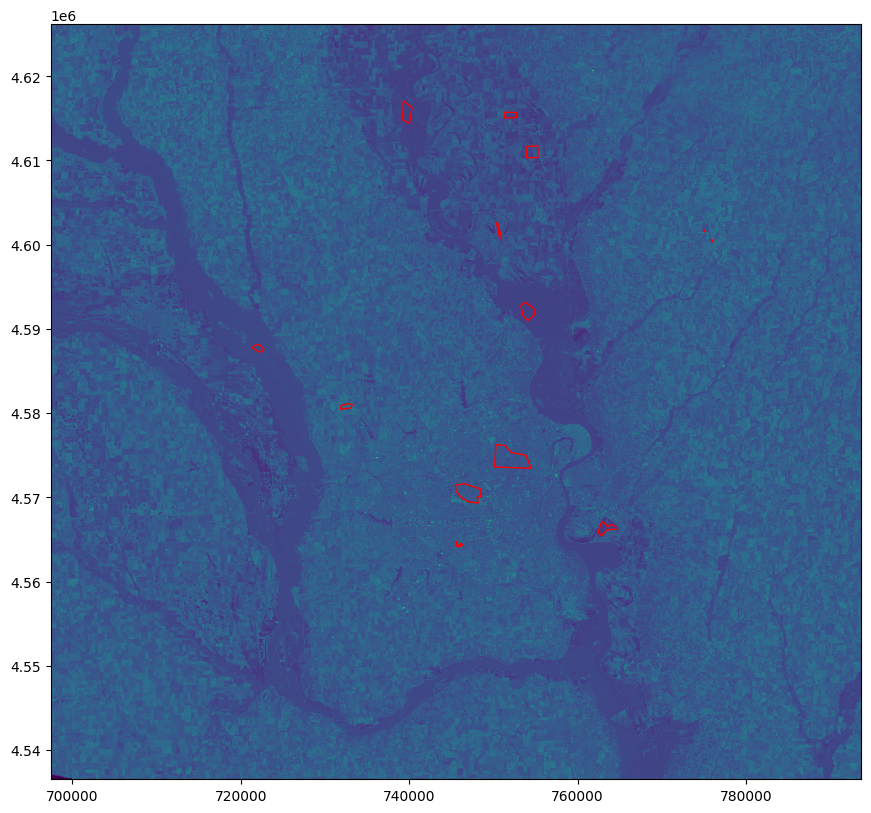

In [17]:
fig,ax=plt.subplots()

show(r.read(5),transform=r.transform,ax=ax)
shp.plot(ax=ax,facecolor='none',edgecolor='red')